# 1.计算香农熵

In [1]:
"""
函数功能：计算香农熵
参数说明：
        dataSet: 原始数据集
返回：
        ent：香农熵的值
"""
def calEnt(dataSet):
    n = dataSet.shape[0]  # 数据集总行数
    iset = dataSet.iloc[:, -1].value_counts()  #标签的所有类别
    p = iset/n              # 每一类标签所占比例
    ent = (-p*np.log2(p)).sum()      #计算信息熵
    return ent

In [2]:
#创建数据集
import numpy as np
import pandas as pd

def createDataSet():
    row_data = {'no surfacing':[1,1,1,0,0],
                'filippers':[1,1,0,1,1],
                'fish':['yes','yes','no','no','no']}
    dataSet = pd.DataFrame(row_data)
    return dataSet

In [3]:
dataSet = createDataSet()
dataSet

,no surfacing,filippers,fish
0,1,1,yes
1,1,1,yes
2,1,0,no
3,0,1,no
4,0,1,no


In [4]:
calEnt(dataSet)

0.9709505944546686

In [5]:
a = (3/5)*(-(2/3)*np.log2(2/3)-(1/3)*np.log2(1/3))
calEnt(dataSet)-a

0.4199730940219749

## 2.数据集最佳切分函数

In [6]:
"""
函数功能：根据信息增益选择出最佳数据集划分的列
参数说明：
        dataSet :原始数据集
返回：
        axis：数据集最佳切分列的索引
"""
#选择最优列进行且分
def bestSplit(dataSet):
    baseEnt = calEnt(dataSet)   #计算原始熵
    bestGain = 0  #初始化信息增益
    axis = -1  #初始化最佳分列，标签列
    for i in range(dataSet.shape[1] - 1):   #对特征的每一列进行循环
        levels = dataSet.iloc[:, i].value_counts().index    #提取出当前列的所有取值
        ents = 0                            #初始化子节点的信息熵
        for j in levels:             #对当前列的每一个取值进行循环
            childSet = dataSet[dataSet.iloc[:, i] == j]    #某一个子节点的dataframe
            ent = calEnt(childSet)    #计算某一个子节点的信息熵
            ents += (childSet.shape[0]/dataSet.shape[0])*ent   #计算当前列的信息熵
            infoGain = baseEnt - ents # 计算当前列的信息增益
            if (infoGain > bestGain):
                bestGain = infoGain  # 选择最大信息增益
                axis = i #最大信息增益所在列的索引
    return axis

In [7]:
bestSplit(dataSet)

0

# 3.按照给定列切分数据集

In [8]:
"""
函数功能：按照给定的列划分数据集
参数说明：
        dataSet :原始数据集
        axis: 指定的列索引
        value：指定的属性值
返回：
        redataSet :按照指定列索引和属性值切分后的数据集
"""
def mySplit(dataSet, axis, value):
    col = dataSet.columns[axis]
    redataSet = dataSet.loc[dataSet[col] == value,:].drop(col,axis = 1)
    return redataSet

In [9]:
value = 1
axis = 0
mySplit(dataSet,axis,value)

,filippers,fish
0,1,yes
1,1,yes
2,0,no


# 4.递归构建决策树

1.ID3 算法

2.编写代码构建决策树

In [10]:
"""
函数功能：基于最大信息增益切分数据集，递归构建决策树
参数说明：
        dataSet:原始数据集（最后一列是标签）
返回：
        myTree:字典形式的树
"""
def createTree(dataSet):
    featlist = list(dataSet.columns)  #提取出数据集中的所有列
    classlist = dataSet.iloc[:, -1].value_counts()   #获取最后一列类标签
    #判断最多标签数目是否等于数据集行数，或者数据集是否只有一列
    if classlist[0] == dataSet.shape[0] or dataSet.shape[1] == 1:
        return classlist.index[0]   #如果是，返回类标签
    axis = bestSplit(dataSet)    #确定出当前最佳且分裂的索引
    bestfeat = featlist[axis]    #获取该索引对应的特征
    myTree = {bestfeat:{}}       #采用字典嵌套的方式存储树信息
    del featlist[axis]           #删除当前特征
    valuelist = set(dataSet.iloc[:, axis])   #提取最佳切分列所有属性值
    for value in valuelist:     #对每一个属性值递归构建树
        myTree[bestfeat][value] = createTree(mySplit(dataSet,axis, value))
    return myTree

In [11]:
myTree = createTree(dataSet)
myTree

{'no surfacing': {0: 'no', 1: {'filippers': {0: 'no', 1: 'yes'}}}}

3. 决策树的存储

In [12]:
#树的存储
np.save('myTree.npy',myTree)

In [13]:
#树的读取
read_myTree = np.load('myTree.npy',allow_pickle=True).item()
read_myTree

{'no surfacing': {0: 'no', 1: {'filippers': {0: 'no', 1: 'yes'}}}}

4.使用决策树执行分类

In [14]:
"""
函数功能：对一个测试实例进行分类
参数说明：
        inputTree: 已经生成的决策树
        labels: 存储选择的最优特征标签
        testvec：测试数据列表，顺序对应原数据集
返回：
        classLabel: 分类结果
"""
def classify(inputTree, labels, testVec):
    firstStr = next(iter(inputTree))   #获取决策树的第一个节点
    secondDict = inputTree[firstStr]   #下一个字典
    featIndex = labels.index(firstStr)   #第一个节点所在列的索引
    for key in secondDict.keys():
        if testVec[featIndex] == key:
            if type(secondDict[key]) == dict:
                classLabel = classify(secondDict[key], labels, testVec)
            else:
                classLabel = secondDict[key]
    return classLabel

In [15]:
"""
函数功能：对测试集进行预测，并返回预测后的结果
参数说明：
        train:训练集
        test: 测试集
返回：
        test: 预测好分类的测试集
"""
def acc_classify (train, test):
    inputTree = createTree(train)   #根据测试集生成一棵树
    labels = list(train.columns)   #数据集所有的列名称
    result =[]
    for i in range(test.shape[0]):    #对测试集中每一条数据进行测试
        testVec = test.iloc[i,:-1]    #测试集中的一个实例
        classLabel = classify(inputTree, labels, testVec) #预测该实例的分类
        result.append(classLabel)       #将分类结果追加到result列表中
    test['predict'] = result           #将预测结果追加到测试集中
    acc = (test.iloc[:, -1] == test.iloc[:,-2]).mean()  #计算准确度
    print(f'模型预测准确度为{acc}')
    return test

# 5.使用Sklearn中graphviz包实现决策树的绘制

In [16]:
#导入相应的包
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
import graphviz

In [17]:
#特征
Xtrain = dataSet.iloc[:,:-1]

In [18]:
#标签
Ytrain = dataSet.iloc[:,-1]
labels = Ytrain.unique().tolist()   #数据清洗
Ytrain = Ytrain.apply(lambda x: labels.index(x))  #将文本转换为数字

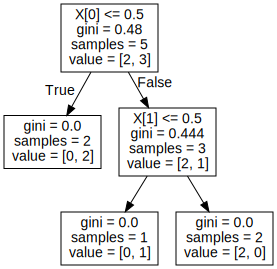

In [19]:
#绘制树模型
clf = DecisionTreeClassifier()
clf = clf.fit(Xtrain, Ytrain)
tree.export_graphviz(clf)
dot_data = tree.export_graphviz(clf, out_file = None)
graphviz.Source(dot_data)

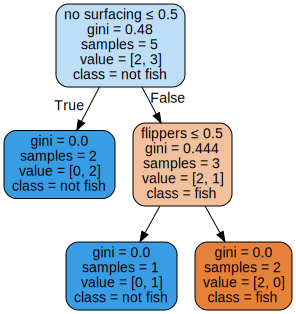

In [20]:
#给图形增加标签和颜色
dot_data = tree.export_graphviz(clf, out_file = None,
                    feature_names = ['no surfacing','flippers'],
                    class_names = ['fish','not fish'],
                    filled = True, rounded = True,
                    special_characters = True)
graphviz.Source(dot_data)

In [21]:
# 利用render方法生成图形
graph = graphviz.Source(dot_data)
graph.render('fish')

'fish.pdf'

# 6.决策树可视化

1.计算叶子节点数目

In [22]:
'''
函数功能：递归计算叶子节点的数目
参数说明：
        myTree：字典形式的树
返回：
        numLeafs: 叶节点数目
'''
def getNumLeafs(myTree):
    numLeafs = 0     #初始化叶节点数目
    firstStr = next(iter(myTree))     #获得树的第一个键值，即第一个特征
    secondDict = myTree[firstStr]    #获取下一组字典
    for key in secondDict.keys():
        if type(secondDict[key]) == dict:   #测试该节点是否为字典
            numLeafs += getNumLeafs(secondDict[key])  #是字典，递归，循环计算分支叶节点数
        else:
            numLeafs += 1       #不是字典，代表此节点为叶子节点
    return numLeafs

2.计算树深度

In [23]:
'''
函数功能：递归计算树的深度
参数说明：
        myTree :字典形式的树
返回：
        maxDepth: 树的最大深度
'''
def getTreeDepth(myTree):
    maxDepth = 0
    firstStr = next(iter(myTree))
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]) == dict:
            thisDepth = 1 + getTreeDepth(secondDict[key])
        else:
            thisDepth = 1
        if thisDepth > maxDepth:
            maxDepth = thisDepth
    return maxDepth

3.绘制节点

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline
#plt.rcParams['font.sans-serif'] = ['SimHei']

In [25]:
"""
函数功能：绘制节点
参数说明：
        nodeTxt:节点名
        centerPt: 文本位置
        parentPt：标注的箭头位置
        nodeType: 节点格式
"""
def plotNode(nodeTxt,cntrPt, parentPt, nodeType):
    arrow_args = dict(arrowstyle = "<-")
    createPlot.ax1.annotate(nodeTxt, 
                           xy = parentPt,xycoords = 'axes fraction',
                            xytext = cntrPt, textcoords = "axes fraction",
                           va = "center", ha = "center",
                           bbox = nodeType,
                           arrowprops = arrow_args)
    

4.标注有向边属性值

In [26]:
"""
函数功能：标注有向边属性值
参数说明：
        cntrPt、parentPt:用于计算标注位置
        txtString: 标注的内容
"""
def plotMidText(cntrPt, parentPt,txtString):
    xMid = (parentPt[0] - cntrPt[0])/2.0 + cntrPt[0]
    yMid = (parentPt[1] - cntrPt[1])/2.0 + cntrPt[1]
    createPlot.ax1.text(xMid, yMid, txtString, va = "center", ha = "center", rotation = 45)

In [27]:
"""
函数功能：绘制决策树
参数说明：
        myTree:决策树（字典）
        parentPt：标注的内容
        nodeTxt:节点名
"""
def plotTree(myTree, parentPt, nodeTxt):
    decisionNode = dict(boxstyle = "sawtooth", fc = "0.8") #设置中间节点格式
    leafNode = dict(boxstyle = "round4", fc = '0.8') #设置叶节点格式
    numLeafs = getNumLeafs(myTree) #获取决策苏叶节点数目，决定了树的宽度
    depth = getTreeDepth(myTree) #获取决策树层数
    firstStr = next(iter(myTree)) #下一个字典
    cntrPt = (plotTree.xOff + (1.0 + float(numLeafs))/2.0/plotTree.totalW,plotTree.yOff)  #确定中心位置
    plotMidText(cntrPt,parentPt,nodeTxt)  #标注有向边属性值
    plotNode(firstStr, cntrPt, parentPt, decisionNode)  #绘制节点
    secondDict = myTree[firstStr]   #下一个字典，也就是继续绘制子节点
    plotTree.yOff = plotTree.yOff - 1.0/plotTree.totalD  #y偏移
    for key in secondDict.keys():
        if type(secondDict[key]) == dict: #测试该节点是否为字典
            plotTree(secondDict[key], cntrPt, str(key))  #是字典则不是叶节点，递归调用继续绘制
        else:
            plotTree.xOff = plotTree.xOff + 1.0/plotTree.totalW #x偏移
            plotNode(secondDict[key], (plotTree.xOff, plotTree.yOff), cntrPt, leafNode)
            plotMidText((plotTree.xOff, plotTree.yOff), cntrPt, str(key))
    plotTree.yOff = plotTree.yOff + 1.0/plotTree.totalD

6.绘制面板

In [28]:
"""
函数功能：创建绘制面板
参数说明：
        inTree:决策树（字典）
"""
def createPlot(inTree):
    fig = plt.figure(1, facecolor = 'white')    #创建fig面板
    fig.clf()    #清空fig
    axprops = dict(xticks = [], yticks =[])
    createPlot.ax1 = plt.subplot(111, frameon = False, ** axprops)  #去掉x、y轴
    plotTree.totalW = float(getNumLeafs(inTree))
    plotTree.totalD = float(getTreeDepth(inTree))
    plotTree.xOff = -0.5/plotTree.totalW
    plotTree.yOff = 1.0
    plotTree(inTree,(0.5,1.0), '')
    plt.show()

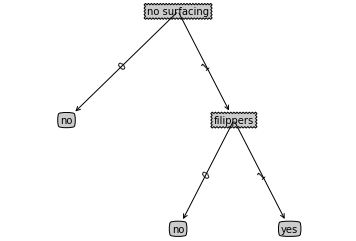

In [29]:
createPlot(myTree)

# 7. 使用决策树预测隐形眼镜类型

In [30]:
lenses = pd.read_table('lenses.txt', header = None)
lenses.columns = ['age', 'prescript', 'astigmatic', 'tearRate', 'class']
lenses

,age,prescript,astigmatic,tearRate,class
0,young,myope,no,reduced,no lenses
1,young,myope,no,normal,soft
2,young,myope,yes,reduced,no lenses
3,young,myope,yes,normal,hard
4,young,hyper,no,reduced,no lenses
5,young,hyper,no,normal,soft
6,young,hyper,yes,reduced,no lenses
7,young,hyper,yes,normal,hard
8,pre,myope,no,reduced,no lenses
9,pre,myope,no,normal,soft


2.划分训练集和测试集

In [31]:
import random

In [32]:
"""
函数功能：划分训练集和测试集
参数说明：
        dataSet: 输入的数据集
        rate: 训练集所占比例
返回：
    train,test:且分好的训练集和测试集
"""
def randSplit(dataSet, rate):
    l = list(dataSet.index)  #提取出索引
    random.shuffle(l)  #随机打乱索引
    dataSet.index = l  #将打乱后的索引重新赋值给原数据集
    n = dataSet.shape[0]  #总行数
    m = int(n * rate)  #训练集的数量
    train = dataSet.loc[range(m), :] #提取前m个记录作为训练集
    test = dataSet.loc[range(m,n),:] #剩下的作为测试集
    dataSet.index = range(dataSet.shape[0])
    test.index = range(test.shape[0])   #更新测试集的索引
    return train, test

In [33]:
dataSet = lenses
rate = 0.8
train1,test1 = randSplit (dataSet,rate)

3.生成决策树并构造注解树

In [34]:
# 利用训练集生成决策树
lensesTree = createTree(train1)
lensesTree

{'age': {'young': {'astigmatic': {'no': 'soft',
    'yes': {'tearRate': {'reduced': 'no lenses', 'normal': 'hard'}}}},
  'presbyopic': {'tearRate': {'normal': {'prescript': {'myope': {'astigmatic': {'no': 'no lenses',
        'yes': 'hard'}},
      'hyper': 'soft'}},
    'reduced': 'no lenses'}},
  'pre': {'prescript': {'myope': {'astigmatic': {'no': 'soft',
      'yes': {'tearRate': {'reduced': 'no lenses', 'normal': 'hard'}}}},
    'hyper': {'astigmatic': {'no': {'tearRate': {'normal': 'soft',
        'reduced': 'no lenses'}},
      'yes': 'no lenses'}}}}}}

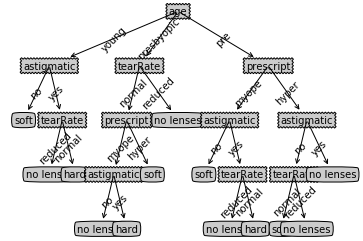

In [35]:
#构造注解树
createPlot(lensesTree)

In [36]:
#用决策树进行分类计算预测准确率
acc_classify(train1, test1)

模型预测准确度为0.2


,age,prescript,astigmatic,tearRate,class,predict
0,young,myope,no,reduced,no lenses,soft
1,young,hyper,no,reduced,no lenses,soft
2,young,myope,yes,reduced,no lenses,no lenses
3,pre,myope,no,reduced,no lenses,soft
4,presbyopic,hyper,yes,normal,no lenses,soft


4.使用Sklearn进行决策树构建

In [40]:
Xtrain1 = train1.iloc[:,:-1].copy() #删除标签列
#因为sklearn输入是数字，需要转换成数字
for i in Xtrain1.columns:
    labels = Xtrain1[i].unique().tolist()
    Xtrain1[i] = Xtrain1[i].apply(lambda x: labels.index(x))

In [43]:
Ytrain1 = train1.iloc[:,-1].copy()
labels = Ytrain1.unique().tolist()
Ytrain1 = Ytrain1.apply(lambda x: labels.index(x))

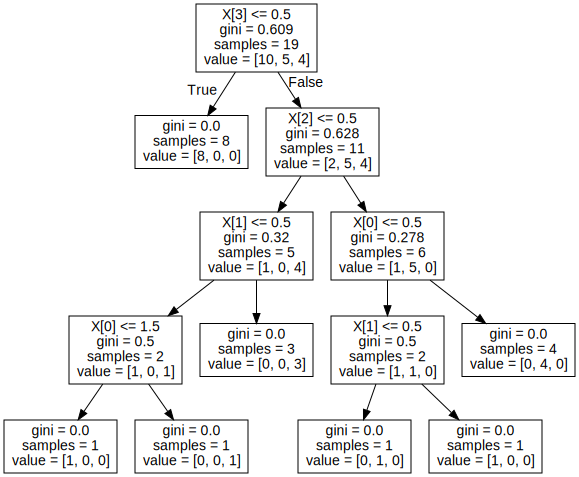

In [44]:
#绘制树形图
clf = DecisionTreeClassifier()
clf = clf.fit(Xtrain1, Ytrain1)
tree.export_graphviz(clf)
dot_data = tree.export_graphviz(clf, out_file = None)
graphviz.Source(dot_data)

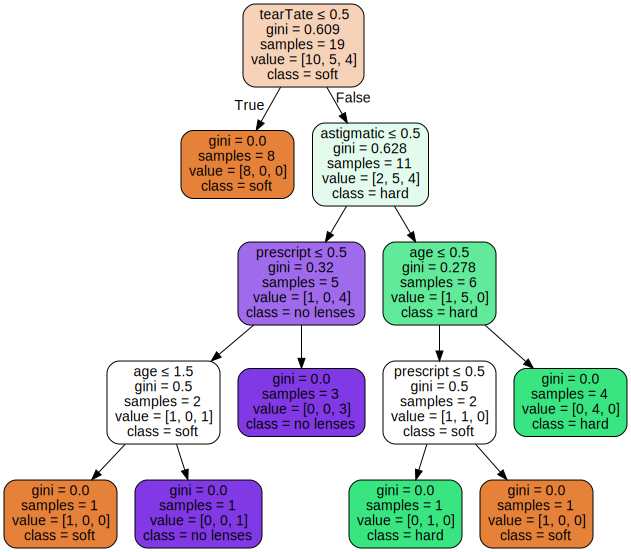

In [45]:
#添加标签和和颜色
dot_data = tree.export_graphviz(clf, out_file = None,
                               feature_names = ['age','prescript','astigmatic','tearTate'],
                               class_names = ['soft','hard','no lenses'],
                               filled = True, rounded = True, special_characters = True)
graphviz.Source(dot_data)

In [46]:
graph = graphviz.Source(dot_data)
graph.render("lense")

'lense.pdf'